In [1]:
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits



/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arnesh/.local/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


(1, 150, 150)
(1, 75, 75)


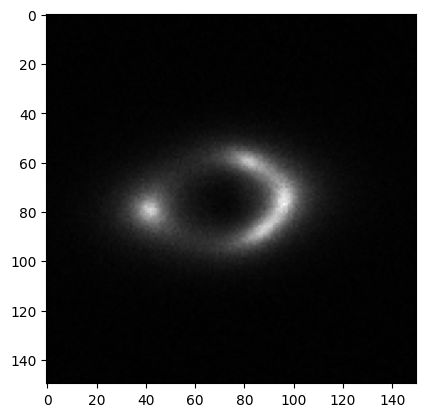

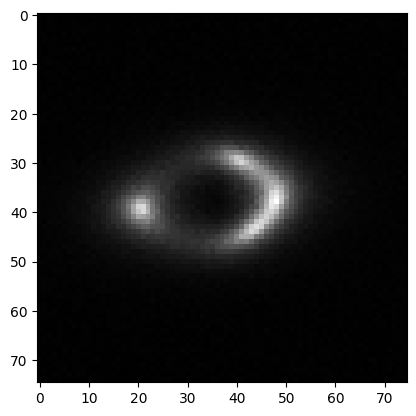

In [2]:
HR_sample = "SR_dataset/HR/sample2.npy"
LR_sample = "SR_dataset/LR/sample2.npy"
HR = np.load(HR_sample)
LR = np.load(LR_sample)
print(HR.shape)
print(LR.shape)

import matplotlib.pyplot as plt
plt.imshow(HR.squeeze() , cmap='gray')
plt.show()
plt.imshow(LR.squeeze() , cmap='gray')
plt.show()

In [3]:
import torch
import torch.nn as nn


class SuperResModel(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm

        self.fc = nn.Linear(self.pos_embedding.shape[-1], 512)

        # Decoder: Project embedding back to image shape (150x150)
        self.decoder = nn.Sequential(
            nn.Linear(512, 128 * 8 * 8),  # Expand to a small spatial feature map
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),  # Reshape to (256, 8, 8)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(64,32, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(32,16, kernel_size=4, stride=2, padding=1),  # (32, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # (3, 128, 128)
            nn.ReLU(),
            nn.Upsample(size=(150, 150), mode="bilinear", align_corners=True),  # Final size (3, 150, 150)
        )

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        features = self.fc(features[0])  # Get the CLS token representation

        # Decode back to an image
        reconstructed_img = self.decoder(features)

        return reconstructed_img




In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2

class SuperResDataset(Dataset):
    def __init__(self, HR_folder, LR_folder):
        self.HR_folder = os.listdir(HR_folder)
        self.LR_folder = os.listdir(LR_folder)
        #Sort the files
        self.HR_folder.sort( key=lambda x: int(x.split('.')[0].split('sample')[1]) )
        self.LR_folder.sort( key=lambda x: int(x.split('.')[0].split('sample')[1]) )
        self.HR_folder = [os.path.join(HR_folder, file) for file in self.HR_folder]
        self.LR_folder = [os.path.join(LR_folder, file) for file in self.LR_folder]


    def __len__(self):
        return len(self.HR_folder)
    
    def __getitem__(self, idx):
        HR = np.load(self.HR_folder[idx])

        LR = np.load(self.LR_folder[idx]).squeeze()
        LR = cv2.resize(LR, (64, 64))

        #Add 3 channels
        LR = np.stack((LR, LR, LR), axis=0)



        return LR, HR
    
HR_folder = "SR_dataset/HR"
LR_folder = "SR_dataset/LR"

dataset = SuperResDataset(HR_folder, LR_folder)
print(len(dataset))
print(dataset[0][0].shape)
print(dataset[0][1].shape)

10000
(3, 64, 64)
(1, 150, 150)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mae = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).to(device)
# pretrain_model/model_vit_t.pth
mae.load_state_dict(torch.load("pretrain_model/model_vit_t.pth", map_location='cpu'))
encoder = mae.encoder
encoder = encoder.float()
encoder = encoder.to(device)
model = SuperResModel(encoder)
model = model.float()
model = model.to(device)

In [6]:
sample = dataset[0]
LR = sample[0]
HR = sample[1]
LR = torch.tensor(LR).float().to(device)
HR = torch.tensor(HR).float().to(device)
LR = LR.unsqueeze(0)
HR = HR.unsqueeze(0)
print(LR.shape)
print(HR.shape)
out = model(LR)
print(out.shape)


torch.Size([1, 3, 64, 64])
torch.Size([1, 1, 150, 150])
torch.Size([1, 1, 150, 150])


100%|██████████| 563/563 [00:44<00:00, 12.60it/s]


Epoch 1/100 - Train Loss: 0.003291 - Test Loss: 0.000641


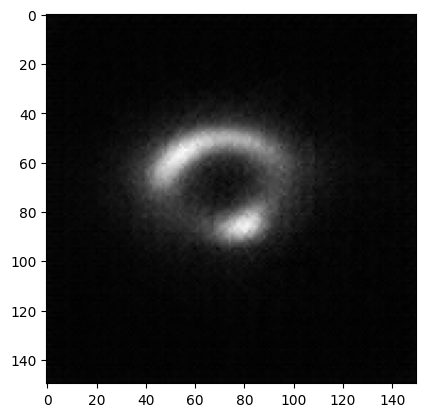

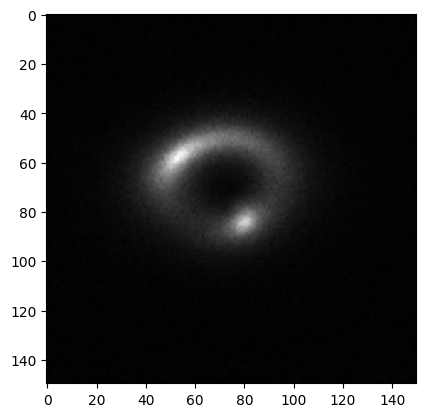

100%|██████████| 563/563 [00:33<00:00, 16.81it/s]


Epoch 2/100 - Train Loss: 0.000501 - Test Loss: 0.000422


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 3/100 - Train Loss: 0.000366 - Test Loss: 0.000339


100%|██████████| 563/563 [00:28<00:00, 19.48it/s]


Epoch 4/100 - Train Loss: 0.000286 - Test Loss: 0.000252


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 5/100 - Train Loss: 0.000241 - Test Loss: 0.000211


100%|██████████| 563/563 [00:29<00:00, 19.08it/s]


Epoch 6/100 - Train Loss: 0.000198 - Test Loss: 0.000188


100%|██████████| 563/563 [00:28<00:00, 19.47it/s]


Epoch 7/100 - Train Loss: 0.000181 - Test Loss: 0.000197


100%|██████████| 563/563 [00:29<00:00, 19.28it/s]


Epoch 8/100 - Train Loss: 0.000168 - Test Loss: 0.000156


100%|██████████| 563/563 [00:29<00:00, 19.30it/s]


Epoch 9/100 - Train Loss: 0.000158 - Test Loss: 0.000178


100%|██████████| 563/563 [00:29<00:00, 18.98it/s]


Epoch 10/100 - Train Loss: 0.000153 - Test Loss: 0.000144


100%|██████████| 563/563 [00:33<00:00, 16.98it/s]


Epoch 11/100 - Train Loss: 0.000147 - Test Loss: 0.000152


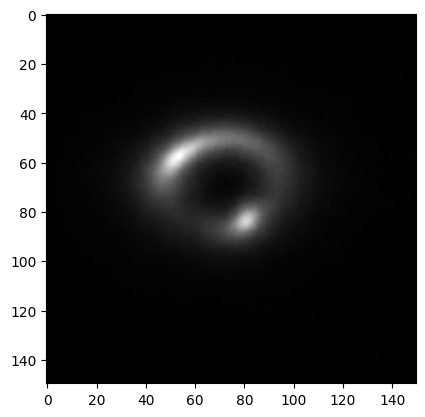

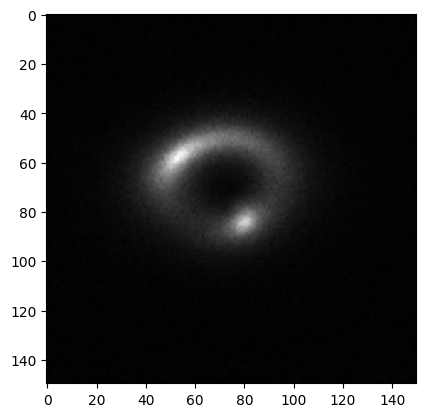

100%|██████████| 563/563 [00:32<00:00, 17.22it/s]


Epoch 12/100 - Train Loss: 0.000139 - Test Loss: 0.000136


100%|██████████| 563/563 [00:33<00:00, 16.69it/s]


Epoch 13/100 - Train Loss: 0.000135 - Test Loss: 0.000145


100%|██████████| 563/563 [00:35<00:00, 15.96it/s]


Epoch 14/100 - Train Loss: 0.000133 - Test Loss: 0.000135


100%|██████████| 563/563 [00:31<00:00, 17.76it/s]


Epoch 15/100 - Train Loss: 0.000128 - Test Loss: 0.000135


100%|██████████| 563/563 [00:29<00:00, 18.93it/s]


Epoch 16/100 - Train Loss: 0.000131 - Test Loss: 0.000142


100%|██████████| 563/563 [00:28<00:00, 19.51it/s]


Epoch 17/100 - Train Loss: 0.000127 - Test Loss: 0.000151


100%|██████████| 563/563 [00:28<00:00, 19.51it/s]


Epoch 18/100 - Train Loss: 0.000124 - Test Loss: 0.000127


100%|██████████| 563/563 [00:29<00:00, 18.81it/s]


Epoch 19/100 - Train Loss: 0.000122 - Test Loss: 0.000126


100%|██████████| 563/563 [00:29<00:00, 18.88it/s]


Epoch 20/100 - Train Loss: 0.000122 - Test Loss: 0.000112


100%|██████████| 563/563 [00:29<00:00, 19.02it/s]


Epoch 21/100 - Train Loss: 0.000119 - Test Loss: 0.000115


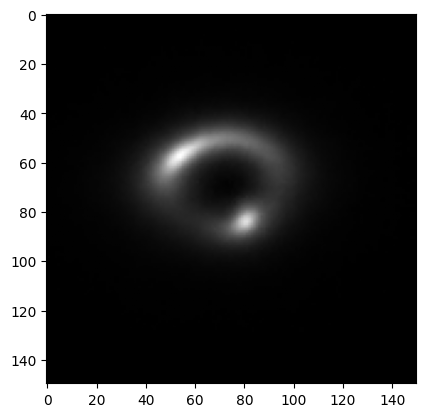

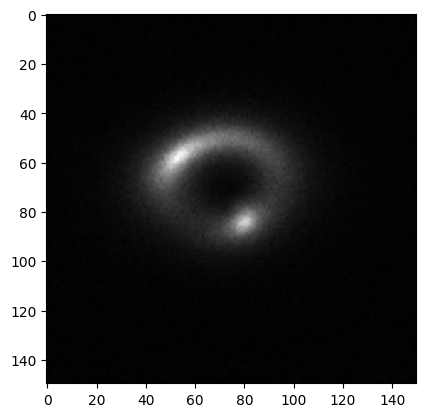

100%|██████████| 563/563 [00:28<00:00, 19.50it/s]


Epoch 22/100 - Train Loss: 0.000117 - Test Loss: 0.000138


100%|██████████| 563/563 [00:28<00:00, 19.56it/s]


Epoch 23/100 - Train Loss: 0.000113 - Test Loss: 0.000121


100%|██████████| 563/563 [00:28<00:00, 19.69it/s]


Epoch 24/100 - Train Loss: 0.000117 - Test Loss: 0.000121


100%|██████████| 563/563 [00:28<00:00, 19.96it/s]


Epoch 25/100 - Train Loss: 0.000113 - Test Loss: 0.000122


100%|██████████| 563/563 [00:28<00:00, 20.08it/s]


Epoch 26/100 - Train Loss: 0.000113 - Test Loss: 0.000115


100%|██████████| 563/563 [00:28<00:00, 20.00it/s]


Epoch 27/100 - Train Loss: 0.000110 - Test Loss: 0.000144


100%|██████████| 563/563 [00:28<00:00, 20.03it/s]


Epoch 28/100 - Train Loss: 0.000110 - Test Loss: 0.000106


100%|██████████| 563/563 [00:28<00:00, 20.00it/s]


Epoch 29/100 - Train Loss: 0.000111 - Test Loss: 0.000111


100%|██████████| 563/563 [00:28<00:00, 20.00it/s]


Epoch 30/100 - Train Loss: 0.000109 - Test Loss: 0.000109


100%|██████████| 563/563 [00:28<00:00, 20.06it/s]


Epoch 31/100 - Train Loss: 0.000107 - Test Loss: 0.000114


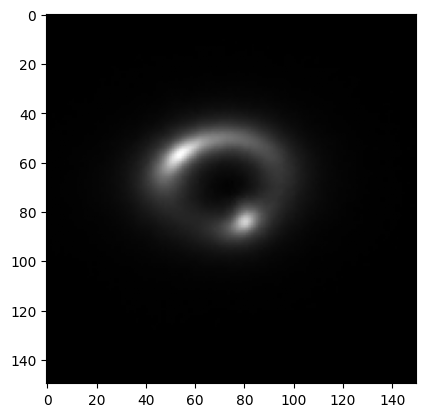

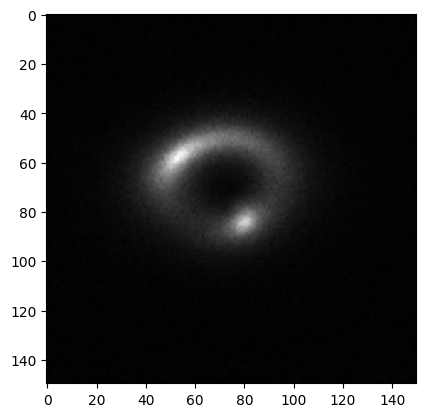

100%|██████████| 563/563 [00:28<00:00, 20.08it/s]


Epoch 32/100 - Train Loss: 0.000107 - Test Loss: 0.000106


100%|██████████| 563/563 [00:27<00:00, 20.16it/s]


Epoch 33/100 - Train Loss: 0.000105 - Test Loss: 0.000105


100%|██████████| 563/563 [00:28<00:00, 20.09it/s]


Epoch 34/100 - Train Loss: 0.000110 - Test Loss: 0.000111


100%|██████████| 563/563 [00:27<00:00, 20.14it/s]


Epoch 35/100 - Train Loss: 0.000103 - Test Loss: 0.000105


100%|██████████| 563/563 [00:27<00:00, 20.12it/s]


Epoch 36/100 - Train Loss: 0.000105 - Test Loss: 0.000108


100%|██████████| 563/563 [00:29<00:00, 19.39it/s]


Epoch 37/100 - Train Loss: 0.000102 - Test Loss: 0.000105


100%|██████████| 563/563 [00:28<00:00, 19.92it/s]


Epoch 38/100 - Train Loss: 0.000109 - Test Loss: 0.000114


100%|██████████| 563/563 [00:28<00:00, 20.03it/s]


Epoch 39/100 - Train Loss: 0.000101 - Test Loss: 0.000102


100%|██████████| 563/563 [00:28<00:00, 19.93it/s]


Epoch 40/100 - Train Loss: 0.000103 - Test Loss: 0.000129


100%|██████████| 563/563 [00:27<00:00, 20.14it/s]


Epoch 41/100 - Train Loss: 0.000101 - Test Loss: 0.000114


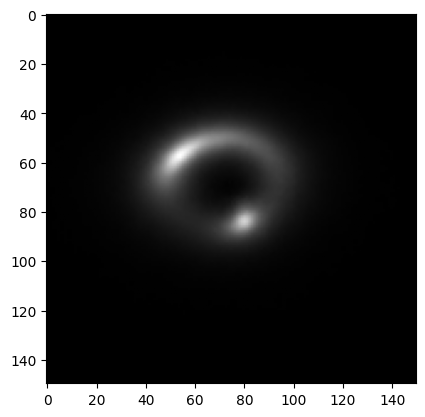

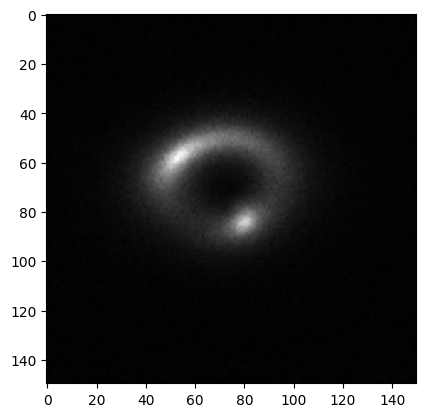

100%|██████████| 563/563 [00:28<00:00, 20.07it/s]


Epoch 42/100 - Train Loss: 0.000102 - Test Loss: 0.000103


100%|██████████| 563/563 [00:28<00:00, 20.04it/s]


Epoch 43/100 - Train Loss: 0.000101 - Test Loss: 0.000106


100%|██████████| 563/563 [00:28<00:00, 20.01it/s]


Epoch 44/100 - Train Loss: 0.000103 - Test Loss: 0.000110


100%|██████████| 563/563 [00:28<00:00, 20.10it/s]


Epoch 45/100 - Train Loss: 0.000099 - Test Loss: 0.000113


100%|██████████| 563/563 [00:28<00:00, 19.75it/s]


Epoch 46/100 - Train Loss: 0.000099 - Test Loss: 0.000106


100%|██████████| 563/563 [00:28<00:00, 20.10it/s]


Epoch 47/100 - Train Loss: 0.000100 - Test Loss: 0.000101


100%|██████████| 563/563 [00:28<00:00, 20.08it/s]


Epoch 48/100 - Train Loss: 0.000099 - Test Loss: 0.000100


100%|██████████| 563/563 [00:28<00:00, 20.09it/s]


Epoch 49/100 - Train Loss: 0.000098 - Test Loss: 0.000098


100%|██████████| 563/563 [00:28<00:00, 20.06it/s]


Epoch 50/100 - Train Loss: 0.000100 - Test Loss: 0.000100


100%|██████████| 563/563 [00:28<00:00, 20.08it/s]


Epoch 51/100 - Train Loss: 0.000097 - Test Loss: 0.000103


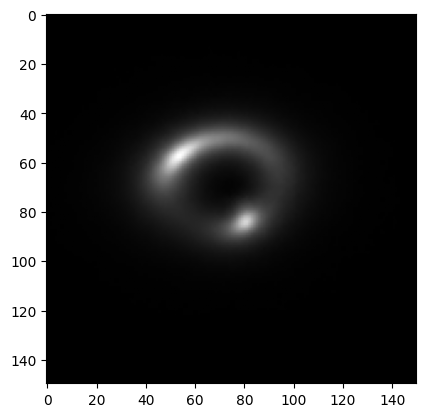

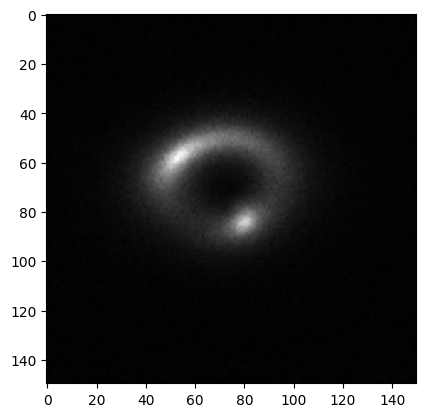

100%|██████████| 563/563 [00:29<00:00, 19.27it/s]


Epoch 52/100 - Train Loss: 0.000100 - Test Loss: 0.000106


100%|██████████| 563/563 [00:29<00:00, 19.41it/s]


Epoch 53/100 - Train Loss: 0.000096 - Test Loss: 0.000100


100%|██████████| 563/563 [00:29<00:00, 19.38it/s]


Epoch 54/100 - Train Loss: 0.000096 - Test Loss: 0.000104


100%|██████████| 563/563 [00:29<00:00, 19.31it/s]


Epoch 55/100 - Train Loss: 0.000096 - Test Loss: 0.000105


100%|██████████| 563/563 [00:29<00:00, 19.33it/s]


Epoch 56/100 - Train Loss: 0.000097 - Test Loss: 0.000095


100%|██████████| 563/563 [00:29<00:00, 19.35it/s]


Epoch 57/100 - Train Loss: 0.000097 - Test Loss: 0.000101


100%|██████████| 563/563 [00:29<00:00, 19.29it/s]


Epoch 58/100 - Train Loss: 0.000096 - Test Loss: 0.000097


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 59/100 - Train Loss: 0.000096 - Test Loss: 0.000100


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 60/100 - Train Loss: 0.000097 - Test Loss: 0.000101


100%|██████████| 563/563 [00:29<00:00, 19.38it/s]


Epoch 61/100 - Train Loss: 0.000095 - Test Loss: 0.000094


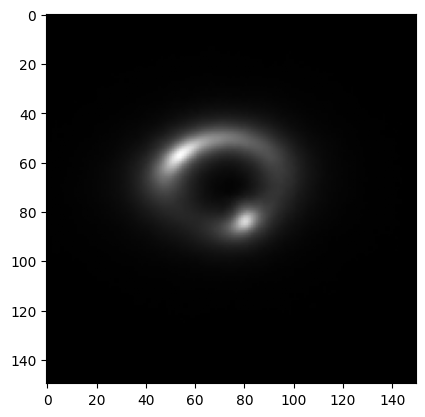

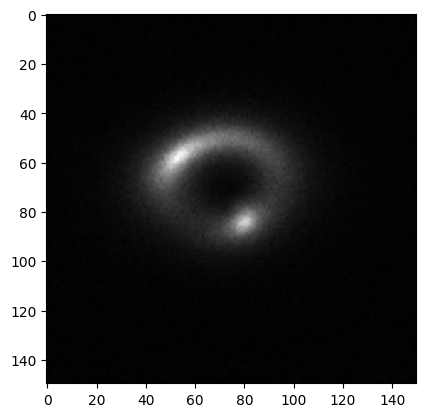

100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 62/100 - Train Loss: 0.000095 - Test Loss: 0.000099


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 63/100 - Train Loss: 0.000097 - Test Loss: 0.000095


100%|██████████| 563/563 [00:29<00:00, 19.32it/s]


Epoch 64/100 - Train Loss: 0.000093 - Test Loss: 0.000097


100%|██████████| 563/563 [00:29<00:00, 19.36it/s]


Epoch 65/100 - Train Loss: 0.000095 - Test Loss: 0.000096


100%|██████████| 563/563 [00:29<00:00, 19.28it/s]


Epoch 66/100 - Train Loss: 0.000095 - Test Loss: 0.000093


100%|██████████| 563/563 [00:29<00:00, 19.31it/s]


Epoch 67/100 - Train Loss: 0.000093 - Test Loss: 0.000092


100%|██████████| 563/563 [00:29<00:00, 19.29it/s]


Epoch 68/100 - Train Loss: 0.000094 - Test Loss: 0.000099


100%|██████████| 563/563 [00:29<00:00, 19.34it/s]


Epoch 69/100 - Train Loss: 0.000094 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.35it/s]


Epoch 70/100 - Train Loss: 0.000092 - Test Loss: 0.000097


100%|██████████| 563/563 [00:29<00:00, 19.32it/s]


Epoch 71/100 - Train Loss: 0.000095 - Test Loss: 0.000093


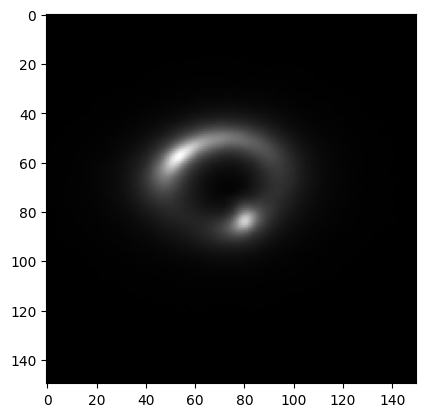

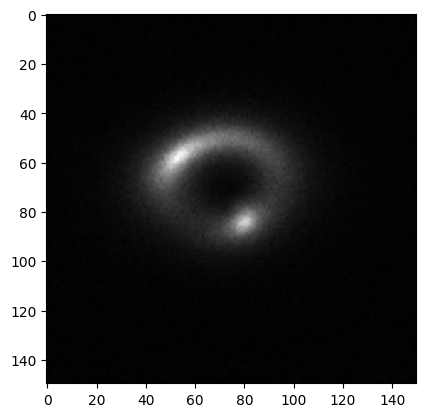

100%|██████████| 563/563 [00:29<00:00, 19.31it/s]


Epoch 72/100 - Train Loss: 0.000093 - Test Loss: 0.000096


100%|██████████| 563/563 [00:29<00:00, 19.32it/s]


Epoch 73/100 - Train Loss: 0.000094 - Test Loss: 0.000097


100%|██████████| 563/563 [00:29<00:00, 19.37it/s]


Epoch 74/100 - Train Loss: 0.000091 - Test Loss: 0.000095


100%|██████████| 563/563 [00:29<00:00, 19.32it/s]


Epoch 75/100 - Train Loss: 0.000092 - Test Loss: 0.000092


100%|██████████| 563/563 [00:29<00:00, 19.35it/s]


Epoch 76/100 - Train Loss: 0.000093 - Test Loss: 0.000093


100%|██████████| 563/563 [00:29<00:00, 19.33it/s]


Epoch 77/100 - Train Loss: 0.000092 - Test Loss: 0.000098


100%|██████████| 563/563 [00:29<00:00, 19.35it/s]


Epoch 78/100 - Train Loss: 0.000092 - Test Loss: 0.000093


100%|██████████| 563/563 [00:29<00:00, 19.25it/s]


Epoch 79/100 - Train Loss: 0.000091 - Test Loss: 0.000090


100%|██████████| 563/563 [00:29<00:00, 19.26it/s]


Epoch 80/100 - Train Loss: 0.000092 - Test Loss: 0.000096


100%|██████████| 563/563 [00:29<00:00, 19.24it/s]


Epoch 81/100 - Train Loss: 0.000092 - Test Loss: 0.000098


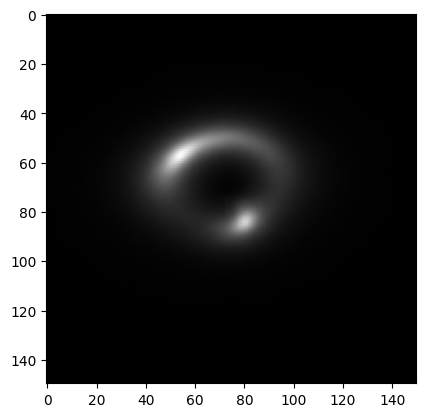

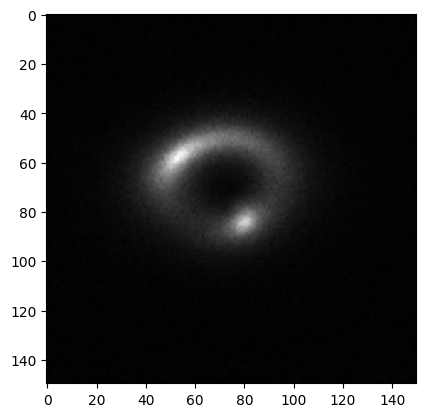

100%|██████████| 563/563 [00:29<00:00, 19.20it/s]


Epoch 82/100 - Train Loss: 0.000092 - Test Loss: 0.000090


100%|██████████| 563/563 [00:29<00:00, 19.35it/s]


Epoch 83/100 - Train Loss: 0.000092 - Test Loss: 0.000091


100%|██████████| 563/563 [00:29<00:00, 19.31it/s]


Epoch 84/100 - Train Loss: 0.000092 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.32it/s]


Epoch 85/100 - Train Loss: 0.000090 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.19it/s]


Epoch 86/100 - Train Loss: 0.000090 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.12it/s]


Epoch 87/100 - Train Loss: 0.000091 - Test Loss: 0.000092


100%|██████████| 563/563 [00:29<00:00, 19.23it/s]


Epoch 88/100 - Train Loss: 0.000093 - Test Loss: 0.000092


100%|██████████| 563/563 [00:29<00:00, 19.15it/s]


Epoch 89/100 - Train Loss: 0.000090 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.20it/s]


Epoch 90/100 - Train Loss: 0.000090 - Test Loss: 0.000095


100%|██████████| 563/563 [00:29<00:00, 19.22it/s]


Epoch 91/100 - Train Loss: 0.000090 - Test Loss: 0.000096


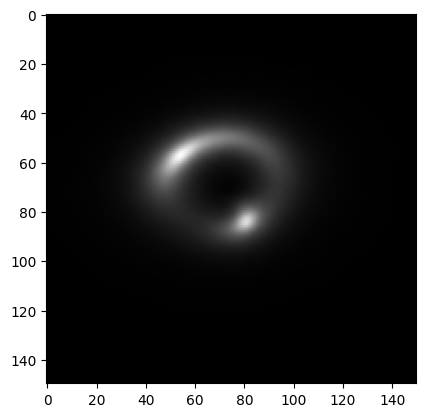

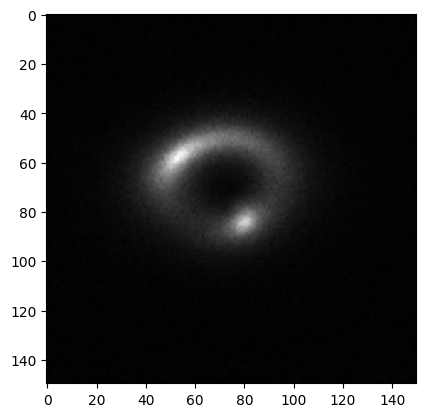

100%|██████████| 563/563 [00:29<00:00, 19.24it/s]


Epoch 92/100 - Train Loss: 0.000090 - Test Loss: 0.000091


100%|██████████| 563/563 [00:29<00:00, 19.03it/s]


Epoch 93/100 - Train Loss: 0.000089 - Test Loss: 0.000091


100%|██████████| 563/563 [00:29<00:00, 19.29it/s]


Epoch 94/100 - Train Loss: 0.000091 - Test Loss: 0.000095


100%|██████████| 563/563 [00:29<00:00, 19.27it/s]


Epoch 95/100 - Train Loss: 0.000090 - Test Loss: 0.000093


100%|██████████| 563/563 [00:29<00:00, 19.30it/s]


Epoch 96/100 - Train Loss: 0.000089 - Test Loss: 0.000094


100%|██████████| 563/563 [00:29<00:00, 19.22it/s]


Epoch 97/100 - Train Loss: 0.000090 - Test Loss: 0.000090


100%|██████████| 563/563 [00:29<00:00, 19.24it/s]


Epoch 98/100 - Train Loss: 0.000090 - Test Loss: 0.000099


100%|██████████| 563/563 [00:29<00:00, 19.04it/s]


Epoch 99/100 - Train Loss: 0.000089 - Test Loss: 0.000092


100%|██████████| 563/563 [00:29<00:00, 19.12it/s]


Epoch 100/100 - Train Loss: 0.000090 - Test Loss: 0.000090


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
from torch.optim import AdamW
from tqdm import tqdm


import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt 





epochs = 100
batch_size = 16
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

test_size = 0.1
dataset_size = len(dataset)

test_size = int(dataset_size * test_size)

train_dataset, test_dataset = random_split(dataset, [dataset_size - test_size, test_size] , generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


optimizer = AdamW(model.parameters(), lr=lr)

criterion = nn.MSELoss()

best_loss = float('inf')


for epoch in range(epochs):
    model.train()
    train_loss = 0
    for LR, HR in tqdm(train_loader):
        LR, HR = LR.to(device).float(), HR.to(device).float()
        optimizer.zero_grad()
        LR , HR = LR.float(), HR.float()
        output = model(LR)
        loss = criterion(output, HR)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for LR, HR in test_loader:
            LR, HR = LR.to(device).float(), HR.to(device).float()
            output = model(LR)
            loss = criterion(output, HR)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f}")

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), "MAE_super_res_model_v2.pth")

        

 
    #Plot the sample image
    if epoch % 10 == 0:
            
        with torch.no_grad():
            LR, HR = test_dataset[0]
            LR = torch.tensor(LR).to(device).float().unsqueeze(0)
            output = model(LR)
            output = output.squeeze().cpu().numpy()
            LR = LR.squeeze().cpu().numpy()
            HR = HR.squeeze()
            plt.imshow(output, cmap='gray')
            plt.show()
            plt.imshow(HR, cmap='gray')
            plt.show()

    
    

In [10]:
MAE = MAE_ViT( image_size=64, patch_size=4, emb_dim=192, encoder_layer=12, encoder_head=3, decoder_layer=4, decoder_head=3, mask_ratio=0.75).to(device)
encoder = MAE.encoder
encoder = encoder.float()
encoder = encoder.to(device)
model = SuperResModel(encoder)
model = model.float()
model = model.to(device)
model.load_state_dict(torch.load("MAE_super_res_model_v2.pthq", map_location='cpu'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

psnr_score = 0
ssim_score = 0
mse_score = 0

for LR, HR in test_loader:
    LR, HR = LR.to(device).float(), HR.to(device).float()
    output = model(LR)
    output = output.detach().cpu().numpy().squeeze()
    HR = HR.squeeze().cpu().numpy()

    psnr_score += psnr(output, HR , data_range= output.max() - output.min())
    
    ssim_score += ssim(output, HR , data_range= output.max() - output.min())

    mse_score += np.mean((output - HR) ** 2)


mse_score /= len(test_loader)
psnr_score /= len(test_loader)
ssim_score /= len(test_loader)

print(f"MSE: {mse_score:.6f} - PSNR: {psnr_score:.6f} - SSIM: {ssim_score:.6f}")


MSE: 0.000090 - PSNR: 40.025167 - SSIM: 0.966675


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#Plot with labels

for LR, HR in test_loader:
    LR, HR = LR.to(device).float(), HR.to(device).float()
    output = model(LR)
    output = output.detach().cpu().numpy().squeeze()
    HR = HR.squeeze().cpu().numpy()
    plt.imshow(output, cmap='gray')
    plt.title("Output")
    plt.show()
    plt.imshow(HR, cmap='gray')
    plt.title("Ground Truth")
    plt.show()
    break
